In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset,random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [9]:
training_data=datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data=datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

validation_data, test_data = random_split(test_data, [5000, 5000])

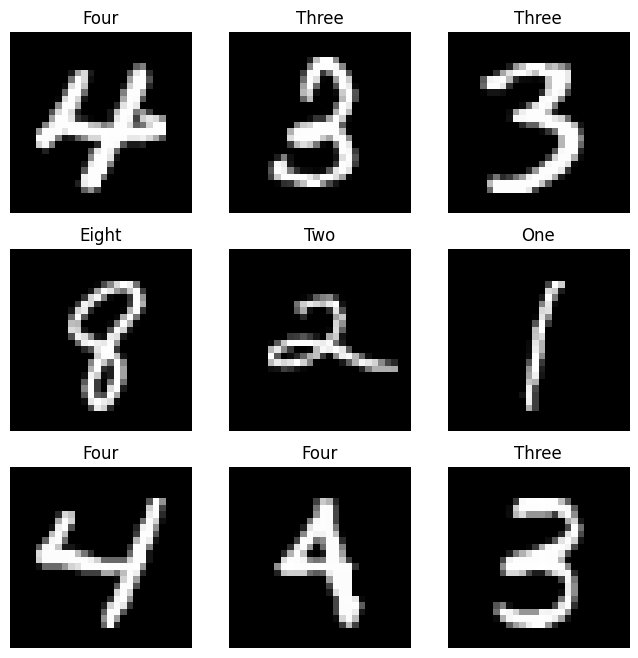

In [10]:
labels_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack=nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1,64,3,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,10)
        )
    def forward(self,X):
        logits=self.linear_relu_stack(X)
        return logits

def train_loop(train_dataloader,val_dataloader,model,loss_fn,optimizer,batch_size,epoch):
    train_size=len(train_dataloader.dataset)
    num_batches=len(train_dataloader)
    loss_tot=0
    train_correct=0

    for batch,(X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()
        pred=model(X)

        loss=loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot+=loss.item()

        model.eval()
        pred=model(X)
        train_correct_each = (pred.argmax(1) == y).type(torch.float).sum().item()
        train_acc=train_correct_each/(y.shape[0])
        train_correct+=train_correct_each
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"\rEpoch {epoch+1} : Training loss: {loss:>7f} - Training Accuracy: {train_acc:>7f}  [{current:>5d}/{train_size:>5d}]", end="")

    loss_avg=loss_tot/num_batches
    train_acc = train_correct/train_size
    val_loss = 0
    val_correct=0
    val_size=len(val_dataloader.dataset)
    model.eval()
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    val_loss /= len(val_dataloader)
    val_acc=val_correct/val_size
    writer.add_scalars('Training vs. Validation Loss',{ 'Training' : loss_avg, 'Validation' : val_loss },epoch +1)
    writer.add_scalars('Training vs. Validation Accuracy',{ 'Training' : train_acc, 'Validation' : val_acc },epoch +1)
    print(f"\rEpoch {epoch+1} : Training loss: {loss_avg:>7f} - Training Accuracy: {train_acc:>7f} - Validation loss: {val_loss:>7f} - Validation accuracy: {val_acc:>7f}")
    print(end='')
    return loss_avg, train_acc, val_loss, val_acc


def test_loop(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    model.eval()
    num_batches=len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc=correct/size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=NeuralNetwork().to(device)

learning_rate = 1e-3
batch_size = 64
epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader=DataLoader(training_data,batch_size,shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=True)
test_dataloader=DataLoader(test_data,batch_size,shuffle=True)

summary(model, (64,1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 28, 28]               2
            Conv2d-2           [-1, 64, 26, 26]             640
              ReLU-3           [-1, 64, 26, 26]               0
       BatchNorm2d-4           [-1, 64, 26, 26]             128
            Conv2d-5           [-1, 64, 24, 24]          36,928
              ReLU-6           [-1, 64, 24, 24]               0
         MaxPool2d-7           [-1, 64, 12, 12]               0
       BatchNorm2d-8           [-1, 64, 12, 12]             128
            Conv2d-9          [-1, 128, 10, 10]          73,856
             ReLU-10          [-1, 128, 10, 10]               0
      BatchNorm2d-11          [-1, 128, 10, 10]             256
           Conv2d-12            [-1, 128, 8, 8]         147,584
             ReLU-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

In [12]:
loss_history = {'train': [], 'val': []}
accuracy_history = {'train': [], 'val': []}

best_val_loss = float('inf')
patience = 3  # How many epochs to wait after last improvement
patience_counter = 0 
min_delta=0.001

for t in range(epochs):
    print(f"Epoch {t+1}",end=" ")
    train_loss, train_accuracy, val_loss, val_accuracy =train_loop(train_dataloader,validation_dataloader, model, loss_fn, optimizer,batch_size,t)
    # test_loop(test_dataloader, model, loss_fn)
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    accuracy_history['train'].append(train_accuracy)
    accuracy_history['val'].append(val_accuracy)

    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        patience_counter += 1 
    
    if patience_counter >= patience:
        print(f"\nStopping early at epoch {t+1} with restoring best weights")
        epochs=t+1
        break 
    
writer.flush()

Epoch 1 : Training loss: 0.082884 - Training Accuracy: 0.963150 - Validation loss: 0.031284 - Validation accuracy: 0.990800
Epoch 2 : Training loss: 0.038968 - Training Accuracy: 0.994167 - Validation loss: 0.027019 - Validation accuracy: 0.990200
Epoch 3 : Training loss: 0.028867 - Training Accuracy: 0.995867 - Validation loss: 0.025977 - Validation accuracy: 0.992400
Epoch 4 : Training loss: 0.023317 - Training Accuracy: 0.997100 - Validation loss: 0.031770 - Validation accuracy: 0.990600
Epoch 5 : Training loss: 0.020810 - Training Accuracy: 0.997450 - Validation loss: 0.022461 - Validation accuracy: 0.993000
Epoch 6 : Training loss: 0.019706 - Training Accuracy: 0.997650 - Validation loss: 0.022354 - Validation accuracy: 0.992400
Epoch 7 : Training loss: 0.013991 - Training Accuracy: 0.998467 - Validation loss: 0.020295 - Validation accuracy: 0.993400
Epoch 8 : Training loss: 0.014471 - Training Accuracy: 0.998517 - Validation loss: 0.020208 - Validation accuracy: 0.993600
Epoch 9 

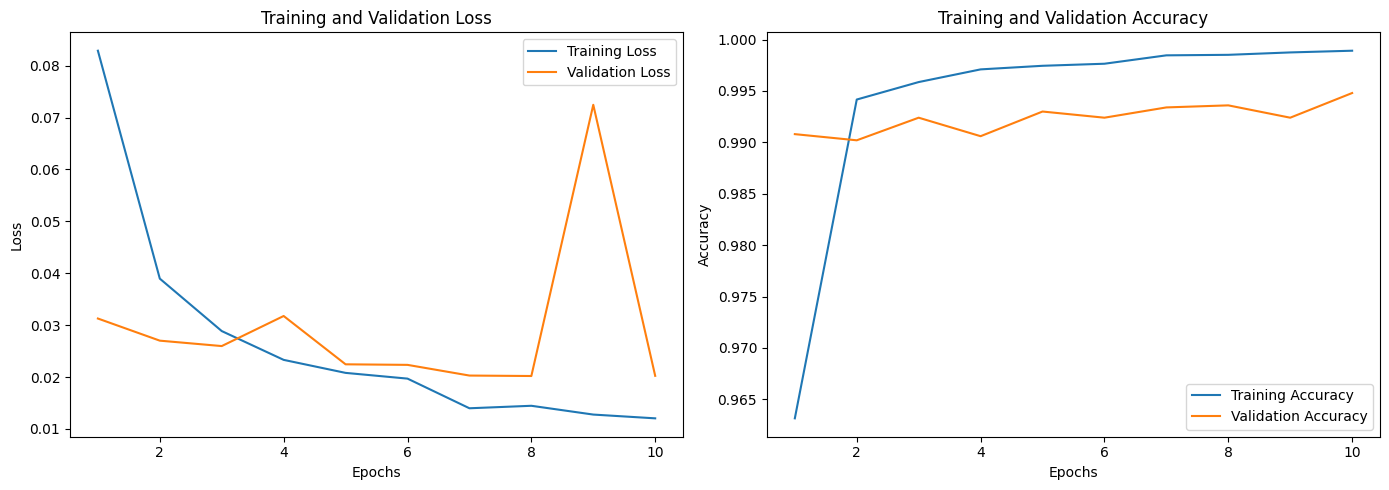

In [13]:
plt.figure(figsize=(14, 5))
eplist=[]
for i in range(epochs):
    eplist.append(i+1)
plt.subplot(1, 2, 1)
plt.plot(eplist, loss_history['train'], label='Training Loss')
plt.plot(eplist, loss_history['val'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eplist, accuracy_history['train'], label='Training Accuracy')
plt.plot(eplist, accuracy_history['val'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()